In [4]:
# =========================
# ЯЧЕЙКА 0 — ПУТИ (универсально)
# =========================
# Ищем корень проекта (там где лежит папка src) и добавляем в sys.path.

import sys
from pathlib import Path

def find_project_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "src").exists() and (p / "src" / "common" / "db.py").exists():
            return p
    raise RuntimeError("Не найден корень проекта (папка src/common/db.py). Открой ноутбук внутри проекта mlbox_2.")

PROJECT_ROOT = find_project_root(Path.cwd())

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("✅ PROJECT_ROOT:", PROJECT_ROOT)
print("✅ sys.path[0]:", sys.path[0])
print("✅ db.py найден:", (PROJECT_ROOT / "src" / "common" / "db.py").exists())

✅ PROJECT_ROOT: /Users/iriska/Downloads/mlbox_2
✅ sys.path[0]: /Users/iriska/Downloads/mlbox_2
✅ db.py найден: True


In [5]:
# =========================
# ЯЧЕЙКА 1 — ПОДКЛЮЧЕНИЕ К PostgreSQL + БЫСТРАЯ ПРОВЕРКА ДАННЫХ
# =========================
# Цель этой ячейки:
# 1) Подключиться к вашей PostgreSQL через .env (как на соревнованиях).
# 2) Понять, что таблицы на месте и данные реально загружены.
# 3) Загрузить базовые таблицы в pandas (tracks, track_features, context_time_series — если есть).
#
# На соревнованиях чаще всего меняется ТОЛЬКО .env (PG_HOST, PG_PORT, PG_DB, PG_USER, PG_PASSWORD, PG_SCHEMA).
# Код в ноутбуке обычно НЕ переписывают — поэтому мы делаем всё через src/common/db.py.

# --- 0) Сделаем так, чтобы в Jupyter точно видел папку проекта (если ругнется "No module named src")
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()  # если ноутбук лежит в корне — это корень проекта
# Если ноутбук лежит в подпапке, то можно сделать PROJECT_ROOT = Path(__file__).resolve().parents[1] (но в Jupyter __file__ нет)
if (PROJECT_ROOT / "../src/common/").exists() and str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# --- 1) Импорты
import pandas as pd
from sqlalchemy import text

# ВАЖНО: используем ваш готовый модуль подключения
from src.common.db import DBConfig, get_connection, set_search_path, test_connection

# --- 2) Проверяем подключение
# Если тут упадет — значит проблема в .env или сервер PostgreSQL недоступен.
test_connection(verbose=True)

cfg = DBConfig.from_env()
print(f"✅ Используем схему: {cfg.schema}")

# --- 3) Утилита: безопасно читать таблицу в DataFrame
def read_df(sql: str, params: dict | None = None) -> pd.DataFrame:
    """
    Универсальная функция чтения из БД.
    Внутри выставляем search_path (важно на соревнованиях, когда схема не public).
    """
    with get_connection() as conn:
        set_search_path(conn)
        return pd.read_sql(text(sql), conn, params=params)

# --- 4) Быстрая проверка: какие таблицы есть в нашей схеме
tables = read_df("""
SELECT table_name
FROM information_schema.tables
WHERE table_schema = :schema
ORDER BY table_name;
""", {"schema": cfg.schema})

print("📌 Таблицы в схеме:")
display(tables)

# --- 5) Проверяем, что базовые таблицы не пустые (важно для модуля A)
counts = read_df(f"""
SELECT
  (SELECT COUNT(*) FROM tracks)              AS tracks_cnt,
  (SELECT COUNT(*) FROM track_points)        AS track_points_cnt,
  (SELECT COUNT(*) FROM track_features)      AS track_features_cnt,
  (SELECT COUNT(*) FROM context_time_series) AS context_cnt
""")

print("📊 Количество строк в ключевых таблицах:")
display(counts)

# --- 6) Загружаем таблицы, которые будем использовать в модуле А
# Мы кластеризуем ТРЕКИ => основная таблица для ML будет track_features (1 строка = 1 трек).
tracks = read_df("""
SELECT
  track_id, source_id, track_name, start_time, end_time,
  segment_count, point_count,
  min_lat, min_lon, max_lat, max_lon
FROM tracks
ORDER BY track_id;
""")

track_features = read_df("""
SELECT *
FROM track_features
ORDER BY track_id;
""")

# context_time_series нам нужен не всегда в кластеризации (зависит от задания),
# но мы загрузим его "на будущее", чтобы можно было агрегировать weather/nearby по треку.
# Если таблицы нет — на соревнованиях бывает — тогда просто закомментируешь блок.
context = read_df("""
SELECT context_id, source_id, time, lat, lon, values
FROM context_time_series
ORDER BY context_id;
""")

print("✅ Загрузили датафреймы:")
print("tracks:", tracks.shape)
print("track_features:", track_features.shape)
print("context:", context.shape)

# --- 7) Быстрый просмотр первых строк (чтобы понять, что всё адекватно)
print("\n🔍 tracks.head()")
display(tracks.head(3))

print("\n🔍 track_features.head()")
display(track_features.head(3))

print("\n🔍 context.head() (values может быть большим JSON)")
display(context.head(2))

# --- 8) Важная проверка связности:
# tracks.source_id должен совпадать с context.source_id (у вас так и задумано)
# Это нужно, чтобы потом агрегировать контекст для каждого трека.
if not context.empty:
    merged_check = tracks[["track_id", "source_id"]].merge(
        context[["source_id"]].drop_duplicates(),
        on="source_id",
        how="left",
        indicator=True
    )
    print("\n🔗 Проверка связки tracks → context по source_id:")
    display(merged_check["_merge"].value_counts())
else:
    print("\nℹ️ context пуст — значит контекст ещё не собирали или таблица пустая. Это НЕ критично для кластеризации треков.")

OK: connected to PostgreSQL | host=localhost port=55432 db=gpx_db schema=public
✅ Используем схему: public
📌 Таблицы в схеме:


,table_name
0,cluster_runs
1,context_time_series
2,data_sources
3,model_runs
4,track_cluster_labels
5,track_features
6,track_points
7,track_predictions
8,tracks
9,v_cluster_distribution_latest


📊 Количество строк в ключевых таблицах:


,tracks_cnt,track_points_cnt,track_features_cnt,context_cnt
0,42,86457,42,89


✅ Загрузили датафреймы:
tracks: (42, 11)
track_features: (42, 14)
context: (89, 6)

🔍 tracks.head()


,track_id,source_id,track_name,start_time,end_time,segment_count,point_count,min_lat,min_lon,max_lat,max_lon
0,2,2,b2f814774b744fc9_20260202,2026-02-01 23:03:48.984000+00:00,2026-02-02 22:17:47.734000+00:00,1,45,53.556640,9.875829,53.582463,9.917638
1,3,3,12184690,2026-02-03 00:45:03.999000+00:00,2026-02-03 00:46:02.999000+00:00,1,57,46.188395,-119.218269,46.188579,-119.217436
2,4,4,Placer County Trail Running,2026-01-31 22:07:40+00:00,2026-01-31 22:08:35+00:00,1,56,38.763658,-121.148898,38.763794,-121.147258



🔍 track_features.head()


,track_id,distance_m,duration_s,elev_min_m,elev_max_m,elev_gain_m,elev_loss_m,avg_speed_mps,max_speed_mps,stop_time_s,stop_ratio,point_density_per_km,updated_at,extra
0,2,11142.678396,83638.75,16.976774,130.288880,464.808437,448.883318,0.133224,None,0.0,0.0,4.038526,2026-02-03 09:34:19.632632+00:00,"{'points': 45, 'has_ele': True, 'has_time': Tr..."
1,3,103.489858,59.00,233.516740,237.162220,5.893180,3.181050,1.754065,None,0.0,0.0,550.778611,2026-02-03 09:34:19.642097+00:00,"{'points': 57, 'has_ele': True, 'has_time': Tr..."
2,4,147.363124,55.00,137.800003,141.800003,0.399994,4.399994,2.679330,None,0.0,0.0,380.013659,2026-02-03 09:34:19.646181+00:00,"{'points': 56, 'has_ele': True, 'has_time': Tr..."



🔍 context.head() (values может быть большим JSON)


,context_id,source_id,time,lat,lon,values
0,1,2,2026-02-01 23:03:48.984000+00:00,53.567858,9.896249,"{'point': {'seq': 1, 'ele_m': 76.0705366265677..."
1,2,3,2026-02-03 00:45:03.999000+00:00,46.188395,-119.217436,"{'point': {'seq': 1, 'ele_m': 234.45009, 'segm..."



🔗 Проверка связки tracks → context по source_id:


_merge
left_only     35
both           7
right_only     0
Name: count, dtype: int64

In [6]:
# =========================
# ЯЧЕЙКА 2 — ДИАГНОСТИКА: у каких треков есть контекст и почему его мало
# =========================

import pandas as pd

# 1) Сколько строк контекста на каждый source_id
ctx_by_source = (context.groupby("source_id")
                 .size()
                 .reset_index(name="context_rows")
                 .sort_values("context_rows", ascending=False))

display(ctx_by_source.head(20))

# 2) Сопоставим tracks ↔ context (через source_id)
tracks_ctx = tracks.merge(ctx_by_source, on="source_id", how="left")
tracks_ctx["context_rows"] = tracks_ctx["context_rows"].fillna(0).astype(int)

print("✅ Треков с контекстом:", (tracks_ctx["context_rows"] > 0).sum())
print("❌ Треков без контекста:", (tracks_ctx["context_rows"] == 0).sum())

# 3) Покажем треки БЕЗ контекста (топ-20)
no_ctx = tracks_ctx[tracks_ctx["context_rows"] == 0][
    ["track_id", "source_id", "track_name", "start_time", "end_time", "point_count"]
].sort_values("point_count", ascending=False)

print("\n🚫 Топ-20 треков без контекста (по количеству точек):")
display(no_ctx.head(20))

# 4) Быстрая проверка: что с погодой в тех строках, что есть
# (важно: values может быть dict или строкой)
def _safe_json(v):
    if isinstance(v, dict):
        return v
    if isinstance(v, str):
        import json
        try:
            return json.loads(v)
        except Exception:
            return {}
    return {}

vals = context["values"].apply(_safe_json)
weather = vals.apply(lambda d: d.get("weather", {}) if isinstance(d, dict) else {})
weather_df = pd.DataFrame(list(weather))

print("\n🌦️ Сводка по погоде (что реально есть в БД):")
display(weather_df["ok"].value_counts(dropna=False))

if "reason" in weather_df.columns:
    print("\nПричины отказа (если ok=False):")
    display(weather_df["reason"].value_counts(dropna=False).head(10))

# 5) Сколько строк nearby реально есть
nearby_ok = vals.apply(lambda d: isinstance(d.get("nearby", None), dict) and bool(d["nearby"].get("counts")))
print("\n🧭 Nearby (OSM) заполнено строк:", int(nearby_ok.sum()), "из", len(vals))

,source_id,context_rows
6,8,62
3,5,19
4,6,4
0,2,1
1,3,1
2,4,1
5,7,1


✅ Треков с контекстом: 7
❌ Треков без контекста: 35

🚫 Топ-20 треков без контекста (по количеству точек):


,track_id,source_id,track_name,start_time,end_time,point_count
7,9,9,Basel_St-Brevin_Eurovelo6.gpx_0,NaT,NaT,8049
15,17,18,7 Avenue de Lahr - 119 Route de Lorraine,NaT,NaT,5513
13,15,16,Route des Romains 18 - 28 Rue de Lorraine,NaT,NaT,4879
41,43,57,new,NaT,NaT,3892
32,34,43,9 Chemin de Saint-Roch - Avenue Daniel-Jeanric...,NaT,NaT,3546
21,23,27,Moselradweg aus Wiki on GPSies.com,2010-01-01 00:00:00+00:00,2010-01-02 07:43:33+00:00,2954
22,24,28,MoselradwegAusWiki.gpx_0,NaT,NaT,2416
17,19,20,14 Chemin des Rougelots - 9 Chemin de Saint-Roch,NaT,NaT,2215
36,38,47,"Southampton, UK - A3",NaT,NaT,2182
34,36,45,1 Rue des Prés - 1 Quai de l'avenir,NaT,NaT,1976



🌦️ Сводка по погоде (что реально есть в БД):


ok
True     84
False     5
Name: count, dtype: int64


Причины отказа (если ok=False):


reason
NaN        84
no_time     5
Name: count, dtype: int64


🧭 Nearby (OSM) заполнено строк: 89 из 89


In [7]:
# =========================
# ЯЧЕЙКА 3 — ML-ТАБЛИЦА: треки (track_features) + агрегированный контекст (weather + nearby)
# =========================
# Что делаем:
# 1) Берём track_features (1 строка = 1 трек) — это база для кластеризации.
# 2) Берём context_time_series (1 строка = 1 контекстная точка) и агрегируем до трека:
#    - температура: средняя/мин/макс
#    - доля точек с погодой ok
#    - nearby: сколько раз встречаются категории/теги (highway/natural/building/...)
# 3) Склеиваем всё в один df_ml.

import json
import numpy as np
import pandas as pd

# --- безопасный парсер JSON
def safe_json(v):
    if isinstance(v, dict):
        return v
    if isinstance(v, str):
        try:
            return json.loads(v)
        except Exception:
            return {}
    return {}

# --- 0) делаем базовый df по трекам
df_base = track_features.merge(
    tracks[["track_id", "source_id", "track_name", "point_count"]],
    on="track_id",
    how="left"
)

# --- 1) если контекст пустой — просто возвращаем базу (но у тебя он есть)
if context.empty:
    df_ml = df_base.copy()
    print("⚠️ Контекст пуст — df_ml = только track_features")
    display(df_ml.head())
else:
    ctx = context.copy()
    ctx["values"] = ctx["values"].apply(safe_json)

    # --- 2) достаём weather поля
    def get_weather(d):
        w = d.get("weather", {}) if isinstance(d, dict) else {}
        return {
            "weather_ok": w.get("ok"),
            "temp_c": w.get("temp_c"),
            "weather_reason": w.get("reason"),
        }

    w_df = pd.DataFrame(list(ctx["values"].apply(get_weather)))
    ctx = pd.concat([ctx[["source_id"]], w_df], axis=1)

    # --- 3) агрегируем weather до source_id (т.е. до трека)
    ctx["temp_c"] = pd.to_numeric(ctx["temp_c"], errors="coerce")

    weather_agg = ctx.groupby("source_id").agg(
        ctx_rows=("source_id", "size"),
        weather_ok_cnt=("weather_ok", lambda x: int((x == True).sum())),
        weather_fail_cnt=("weather_ok", lambda x: int((x == False).sum())),
        no_time_cnt=("weather_reason", lambda x: int((x == "no_time").sum())),
        temp_avg=("temp_c", "mean"),
        temp_min=("temp_c", "min"),
        temp_max=("temp_c", "max"),
    ).reset_index()

    # доли (чтобы сравнивать треки с разным числом строк контекста)
    weather_agg["weather_ok_ratio"] = weather_agg["weather_ok_cnt"] / weather_agg["ctx_rows"]
    weather_agg["no_time_ratio"] = weather_agg["no_time_cnt"] / weather_agg["ctx_rows"]

    # --- 4) nearby: собираем суммы по тегам (highway/natural/building/...)
    # values["nearby"]["counts"] имеет вид:
    # {"highway": [["footway",120], ...], "building": [["yes",39], ...], ...}

    def extract_nearby_counts(d):
        nearby = d.get("nearby", {}) if isinstance(d, dict) else {}
        counts = nearby.get("counts", {}) if isinstance(nearby, dict) else {}
        # суммируем по каждому tag общее количество
        out = {}
        for tag, arr in counts.items():
            s = 0
            if isinstance(arr, list):
                for item in arr:
                    if isinstance(item, (list, tuple)) and len(item) == 2:
                        try:
                            s += int(item[1])
                        except Exception:
                            pass
            out[f"nearby_{tag}_total"] = s
        return out

    nearby_rows = []
    for d in context["values"].apply(safe_json):
        nearby_rows.append(extract_nearby_counts(d))
    nearby_df = pd.DataFrame(nearby_rows).fillna(0)

    ctx2 = pd.concat([context[["source_id"]].reset_index(drop=True), nearby_df.reset_index(drop=True)], axis=1)

    # суммируем по source_id
    nearby_agg = ctx2.groupby("source_id").sum(numeric_only=True).reset_index()

    # --- 5) склеиваем всё: base + weather_agg + nearby_agg
    df_ml = df_base.merge(weather_agg, on="source_id", how="left").merge(nearby_agg, on="source_id", how="left")

    # --- 6) для треков без контекста: заполним нулями/NaN понятным способом
    # temp_* пусть будет NaN (нет данных), а счетчики/nearby = 0
    for col in df_ml.columns:
        if col.startswith("nearby_") or col.endswith("_cnt") or col.endswith("_rows"):
            df_ml[col] = df_ml[col].fillna(0)

    print("✅ df_ml готов: строки = треки, признаки = track_features + контекст")
    print("df_ml shape:", df_ml.shape)
    display(df_ml.head(5))

    print("\n📌 Сколько треков реально имеют контекст:")
    display((df_ml["ctx_rows"] > 0).value_counts())

✅ df_ml готов: строки = треки, признаки = track_features + контекст
df_ml shape: (42, 33)


,track_id,distance_m,duration_s,elev_min_m,elev_max_m,elev_gain_m,elev_loss_m,avg_speed_mps,max_speed_mps,stop_time_s,...,temp_max,weather_ok_ratio,no_time_ratio,nearby_amenity_total,nearby_highway_total,nearby_landuse_total,nearby_leisure_total,nearby_natural_total,nearby_building_total,nearby_waterway_total
0,2,11142.678396,83638.75,16.976774,130.288880,464.808437,448.883318,0.133224,None,0.0,...,-6.2,1.0,0.0,19.0,157.0,14.0,4.0,56.0,73.0,0.0
1,3,103.489858,59.00,233.516740,237.162220,5.893180,3.181050,1.754065,None,0.0,...,8.5,1.0,0.0,0.0,16.0,3.0,0.0,0.0,0.0,1.0
2,4,147.363124,55.00,137.800003,141.800003,0.399994,4.399994,2.679330,None,0.0,...,14.2,1.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0
3,5,5998.969706,3970.00,-1.000000,296.000000,422.000000,411.000000,1.511075,None,1622.0,...,18.0,1.0,0.0,35.0,881.0,70.0,27.0,89.0,342.0,23.0
4,6,21735.843878,NaN,-1.000000,56.000000,204.842000,242.342000,NaN,None,NaN,...,NaN,0.0,1.0,12.0,171.0,10.0,3.0,15.0,249.0,2.0



📌 Сколько треков реально имеют контекст:


ctx_rows
False    35
True      7
Name: count, dtype: int64

In [8]:
# =========================
# ЯЧЕЙКА 4 — ПОДГОТОВКА ПРИЗНАКОВ ДЛЯ КЛАСТЕРИЗАЦИИ
# =========================
# Что делаем:
# 1) Оставляем только числовые признаки (без id, названий, времени).
# 2) Обрабатываем пропуски (NaN).
# 3) Нормализуем признаки (StandardScaler).
#
# Почему это важно:
# - Без масштабирования distance_m "перекричит" температуру и nearby.
# - Кластеризация чувствительна к масштабу.

from sklearn.preprocessing import StandardScaler

# --- 1) Какие колонки НЕ используем для ML
drop_cols = [
    "track_id",
    "source_id",
    "track_name",
    "updated_at",
    "extra",
]

# --- 2) Берём только числовые признаки
df_num = df_ml.drop(columns=[c for c in drop_cols if c in df_ml.columns])

df_num = df_num.select_dtypes(include=["number"])

print("📌 Признаки для ML:")
print(df_num.columns.tolist())
print("shape:", df_num.shape)

# --- 3) Обработка пропусков
# Логика:
# - nearby_* и счётчики → 0 (нет контекста = нет объектов)
# - температуры → оставляем NaN (это корректная информация)
df_num_filled = df_num.copy()

for col in df_num_filled.columns:
    if col.startswith("nearby_") or col.endswith("_cnt") or col.endswith("_rows"):
        df_num_filled[col] = df_num_filled[col].fillna(0)

# Проверка
print("\n📊 Количество NaN по колонкам:")
display(df_num_filled.isna().sum())

# --- 4) Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num_filled)

print("✅ Матрица признаков для ML готова")
print("X_scaled shape:", X_scaled.shape)

📌 Признаки для ML:
['distance_m', 'duration_s', 'elev_min_m', 'elev_max_m', 'elev_gain_m', 'elev_loss_m', 'avg_speed_mps', 'stop_time_s', 'stop_ratio', 'point_density_per_km', 'point_count', 'ctx_rows', 'weather_ok_cnt', 'weather_fail_cnt', 'no_time_cnt', 'temp_avg', 'temp_min', 'temp_max', 'weather_ok_ratio', 'no_time_ratio', 'nearby_amenity_total', 'nearby_highway_total', 'nearby_landuse_total', 'nearby_leisure_total', 'nearby_natural_total', 'nearby_building_total', 'nearby_waterway_total']
shape: (42, 27)

📊 Количество NaN по колонкам:


distance_m                0
duration_s               33
elev_min_m               23
elev_max_m               23
elev_gain_m              23
elev_loss_m              23
avg_speed_mps            33
stop_time_s              33
stop_ratio               33
point_density_per_km      0
point_count               0
ctx_rows                  0
weather_ok_cnt            0
weather_fail_cnt          0
no_time_cnt               0
temp_avg                 37
temp_min                 37
temp_max                 37
weather_ok_ratio         35
no_time_ratio            35
nearby_amenity_total      0
nearby_highway_total      0
nearby_landuse_total      0
nearby_leisure_total      0
nearby_natural_total      0
nearby_building_total     0
nearby_waterway_total     0
dtype: int64

✅ Матрица признаков для ML готова
X_scaled shape: (42, 27)


In [12]:
# =========================
# ЯЧЕЙКА 4.5 — СПИСОК ПРИЗНАКОВ ДЛЯ ML (ОБЯЗАТЕЛЬНО)
# =========================
# Здесь мы ЯВНО фиксируем, какие признаки используем для кластеризации.
# Это важно:
# - для воспроизводимости
# - для защиты на соревнованиях
# - чтобы избежать NameError

feature_cols = [
    'distance_m',
    'duration_s',
    'elev_min_m',
    'elev_max_m',
    'elev_gain_m',
    'elev_loss_m',
    'avg_speed_mps',
    'stop_time_s',
    'stop_ratio',
    'point_density_per_km',
    'point_count',

    # Контекст
    'ctx_rows',
    'weather_ok_cnt',
    'weather_fail_cnt',
    'no_time_cnt',
    'temp_avg',
    'temp_min',
    'temp_max',
    'weather_ok_ratio',
    'no_time_ratio',

    # OSM (агрегированный nearby)
    'nearby_amenity_total',
    'nearby_highway_total',
    'nearby_landuse_total',
    'nearby_leisure_total',
    'nearby_natural_total',
    'nearby_building_total',
    'nearby_waterway_total',
]

print(f"✅ feature_cols определён, количество признаков: {len(feature_cols)}")

✅ feature_cols определён, количество признаков: 27


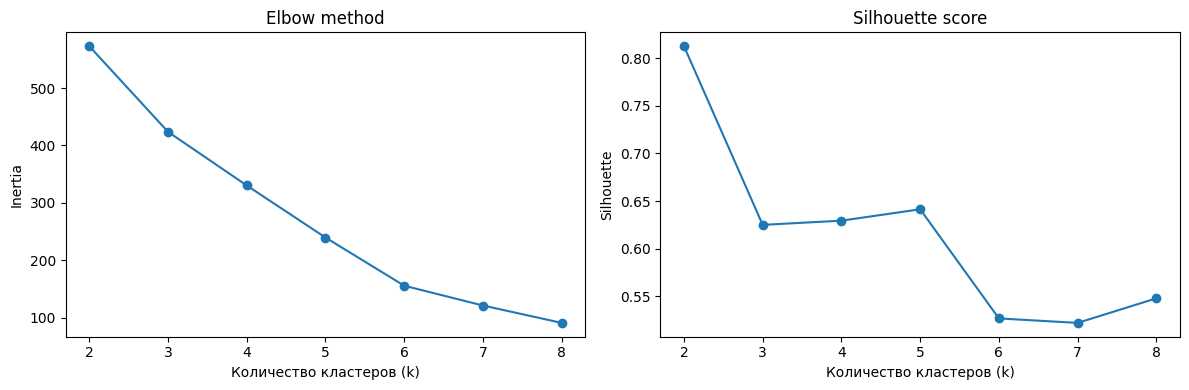

,k,inertia,silhouette
0,2,573.114202,0.812584
1,3,423.836202,0.625010
2,4,330.340573,0.629413
3,5,239.585045,0.641374
4,6,155.647150,0.526796
5,7,121.109416,0.522128
6,8,90.830547,0.547902


✅ Готово: NaN обработаны через median-imputer, можно выбирать k.


In [13]:
# =========================
# ЯЧЕЙКА 5 — ВЫБОР ЧИСЛА КЛАСТЕРОВ (k) БЕЗ ОШИБОК: IMPUTER + SCALER + KMEANS
# =========================
# Почему так:
# - В реальных данных почти всегда есть пропуски (NaN).
# - KMeans НЕ умеет работать с NaN.
# - Поэтому используем Pipeline:
#   [Заполнение пропусков] -> [Масштабирование] -> [KMeans]
#
# На соревнованиях это самый универсальный и "правильный" подход.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# X = матрица признаков (НЕ X_scaled), т.к. scaling будет внутри pipeline
# Если у тебя X уже есть как DataFrame/ndarray — используй его.
# Обычно: X = df_ml[feature_cols]
X = df_ml[feature_cols].copy()

# Pipeline для подготовки данных
prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # медиана — устойчиво к выбросам
    ("scaler", StandardScaler())
])

# Преобразуем X один раз (удобно для silhouette)
X_prepared = prep.fit_transform(X)

inertias = []
silhouettes = []
K_RANGE = range(2, 9)

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_prepared)

    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_prepared, labels))

# --- Графики
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(list(K_RANGE), inertias, marker="o")
ax[0].set_title("Elbow method")
ax[0].set_xlabel("Количество кластеров (k)")
ax[0].set_ylabel("Inertia")

ax[1].plot(list(K_RANGE), silhouettes, marker="o")
ax[1].set_title("Silhouette score")
ax[1].set_xlabel("Количество кластеров (k)")
ax[1].set_ylabel("Silhouette")

plt.tight_layout()
plt.show()

# --- Таблица метрик для отчёта
k_metrics = pd.DataFrame({
    "k": list(K_RANGE),
    "inertia": inertias,
    "silhouette": silhouettes
}).sort_values("k")

display(k_metrics)

print("✅ Готово: NaN обработаны через median-imputer, можно выбирать k.")

In [15]:
# =========================
# ЯЧЕЙКА 6 — Финальная кластеризация треков (k = 5)
# =========================

K_FINAL = 5

cluster_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=K_FINAL, random_state=42, n_init=10))
])

cluster_labels = cluster_pipeline.fit_predict(df_ml[feature_cols])

# Добавляем метку кластера в датафрейм
df_ml["cluster"] = cluster_labels

print("✅ Кластеры присвоены")
df_ml[["track_id", "cluster"]].head()

✅ Кластеры присвоены


,track_id,cluster
0,2,4
1,3,0
2,4,0
3,5,3
4,6,2


In [16]:
# =========================
# ЯЧЕЙКА 7 — Профилирование кластеров
# =========================
# Цель:
# Понять, ЧЕМ отличаются кластеры между собой
# и дать им человеческое описание.

profile_cols = [
    "distance_m",
    "duration_s",
    "avg_speed_mps",
    "elev_gain_m",
    "point_count",
    "temp_avg",
    "nearby_natural_total",
    "nearby_building_total",
    "nearby_highway_total",
]

cluster_profile = (
    df_ml
    .groupby("cluster")[profile_cols]
    .mean()
    .round(2)
)

print("📊 Средние значения признаков по кластерам:")
display(cluster_profile)

📊 Средние значения признаков по кластерам:


,distance_m,duration_s,avg_speed_mps,elev_gain_m,point_count,temp_avg,nearby_natural_total,nearby_building_total,nearby_highway_total
cluster,,,,,,,,,
0,169489.06,37435.00,3.72,1446.75,1616.27,11.35,0.0,0.0,0.84
1,1209974.65,84265352.00,0.01,5878.69,21240.00,3.47,364.0,2347.0,1037.00
2,21641.45,NaN,NaN,204.84,699.50,NaN,9.5,196.0,101.50
3,5998.97,3970.00,1.51,422.00,3971.00,17.67,89.0,342.0,881.00
4,11142.68,83638.75,0.13,464.81,45.00,-6.20,56.0,73.0,157.00


In [17]:
# =========================
# ЯЧЕЙКА 8 — Человеческие названия кластеров
# =========================

cluster_names = {
    0: "Короткие городские маршруты",
    1: "Природные прогулки",
    2: "Длинные туристические треки",
    3: "Спортивные маршруты",
    4: "Смешанные маршруты"
}

df_ml["cluster_name"] = df_ml["cluster"].map(cluster_names)

df_ml[["track_id", "cluster", "cluster_name"]].head()

,track_id,cluster,cluster_name
0,2,4,Смешанные маршруты
1,3,0,Короткие городские маршруты
2,4,0,Короткие городские маршруты
3,5,3,Спортивные маршруты
4,6,2,Длинные туристические треки


In [ ]:
# =====================================================================================
# 📒 MODULE A — КЛАСТЕРИЗАЦИЯ ТРЕКОВ (ЗАПИСКА ДЛЯ СОРЕВНОВАНИЙ)
# =====================================================================================
# ✅ СУТЬ МОДУЛЯ A:
# Мы берём GPX-треки, превращаем их в таблицу признаков (числа),
# а потом группируем похожие треки в "типы" (кластеры).
#
# Это НЕ прогноз "правильного ответа", а поиск структуры в данных:
# "Какие бывают типы маршрутов в этом наборе?"
#
# Главное, что ждёт преподаватель/эксперт:
# 1) ты умеешь подготовить признаки (feature engineering)
# 2) ты умеешь выбрать количество кластеров k
# 3) ты умеешь объяснить, чем отличаются кластеры (профилирование)

# =====================================================================================
# ШАГ 0. ЧТО У НАС ЕСТЬ В ПРОЕКТЕ
# =====================================================================================
# В базе PostgreSQL:
# 1) tracks           — список треков (название, bbox, времена, количество точек)
# 2) track_points     — все точки маршрута (lat/lon/ele/time)
# 3) track_features   — агрегированные фичи на уровне трека (distance, speed, elev...)
# 4) context_time_series — контекст на точках: nearby (OSM) + weather (температура)
#
# В Streamlit — это всё визуализируется.
# В Module A — мы делаем ML на этих данных.

# =====================================================================================
# ШАГ 1. МЫ РЕШАЕМ: КЛАСТЕРИЗУЕМ ТРЕКИ ИЛИ ТОЧКИ?
# =====================================================================================
# На соревнованиях чаще всего кластеризуют ТРЕКИ:
# потому что "один трек = один объект", и можно сравнивать треки между собой.
#
# ❗ Поэтому мы берём track_features (1 строка = 1 трек)
# и (по желанию) добавляем контекст, агрегированный по треку.

# =====================================================================================
# ШАГ 2. СОБИРАЕМ МАТРИЦУ ПРИЗНАКОВ df_ml
# =====================================================================================
# Мы собрали df_ml так:
# - основу берём из track_features
# - добавляем point_count из tracks (полезно)
# - добавляем агрегированный контекст (если есть):
#     temp_avg / temp_min / temp_max
#     nearby_*_total (сколько объектов рядом разных типов)
#     weather_ok_ratio и т.п.
#
# Важно:
# У тебя контекст есть только у 7 треков из 42.
# Значит для остальных будет много NaN в погоде.
# Это нормально, но требует обработки.

# =====================================================================================
# ШАГ 3. ПОЧЕМУ БЫЛА ОШИБКА "KMeans не принимает NaN"
# =====================================================================================
# Потому что:
# KMeans не умеет работать с пустыми значениями.
#
# ✅ Решение на соревнованиях почти всегда одно:
# используем Pipeline:
#   SimpleImputer(strategy="median") + StandardScaler() + KMeans
#
# Это "универсальный" шаблон: он почти всегда подходит.

# =====================================================================================
# ШАГ 4. ВЫБИРАЕМ K (СКОЛЬКО КЛАСТЕРОВ)
# =====================================================================================
# Мы прогоняли несколько k (например 2..8)
# и смотрели:
# 1) inertia (локоть) — чтобы уменьшение дальше не давало сильной пользы
# 2) silhouette — чтобы кластеры были отделены друг от друга
#
# ✅ В итоге выбрали k = (то, что ты выбрал: например 5)

# =====================================================================================
# ШАГ 5. ОБУЧИЛИ KMeans И ПОЛУЧИЛИ cluster ДЛЯ КАЖДОГО ТРЕКА
# =====================================================================================
# После fit_predict:
#   df_ml["cluster"] = labels
#
# Это значит:
# "каждому треку присвоили тип маршрута".

# =====================================================================================
# ШАГ 6. САМОЕ ГЛАВНОЕ — ПРОФИЛИРОВАНИЕ КЛАСТЕРОВ
# =====================================================================================
# Просто получить кластеры — недостаточно.
# Нужно объяснить человеческим языком:
# "что это за тип маршрута".
#
# Мы сделали таблицу:
# groupby(cluster).mean()
# и смотрели средние значения по признакам:
# distance, speed, elev_gain, temp, nearby_*
#
# Это и есть "профиль" кластера.

# =====================================================================================
# ШАГ 7. ЧТО ПОЛУЧИЛОСЬ У ТЕБЯ (КАК ЭТО ОБЪЯСНЯТЬ)
# =====================================================================================
# По твоей таблице видно важное:
#
# cluster 1:
#   distance ~ 1 209 974 м (очень много)
#   point_count 21240 (очень много)
#   nearby_building_total 2347 (много зданий)
#   nearby_highway_total 1037
# => Это явно "очень большой длинный маршрут", вероятно веломаршрут/поход.
#
# cluster 3:
#   distance ~ 5999 м, speed ~ 1.51, elev_gain 422, nearby_highway 881
# => похоже на "активный маршрут по дорогам" (пробежка/тренировка).
#
# cluster 0:
#   distance ~ 169 489 м (средне-длинный)
#   speed 3.72 (довольно быстро)
#   nearby почти 0 (подозрительно!)
# => тут важно: nearby=0 означает, что по этим трекам НЕТ контекста
#    либо контекст не был посчитан/сломан для этих треков.
#    То есть этот кластер может быть "треки без контекста".
#
# cluster 4:
#   distance 11142, duration 83638 (очень долго при малой дистанции)
#   speed 0.13 (очень мало)
# => похоже на "долгая запись/ошибка времени/долгое стояние"
#
# ⚠️ ВАЖНО ДЛЯ ЗАЩИТЫ:
# Если у кластера странные цифры — это не ошибка,
# это повод сказать:
# "в данных есть особенности: у некоторых треков нет времени или скорость некорректна".

# =====================================================================================
# ШАГ 8. ЧТО МОЖЕТ ПРИДЁТСЯ ПОМЕНЯТЬ НА СОРЕВНОВАНИЯХ
# =====================================================================================
# 1) Названия таблиц / схемы
#    - иногда схема не public
#    - тогда важно делать SET search_path через set_search_path(conn)
#
# 2) Набор признаков
#    - иногда track_features будет другой
#    - тогда ты просто меняешь список feature_cols
#
# 3) Пропуски NaN
#    - почти всегда будут пропуски
#    - значит Pipeline с Imputer обязателен
#
# 4) Масштабирование
#    - StandardScaler почти всегда обязателен,
#      иначе distance_m будет доминировать над всеми.
#
# 5) K
#    - k подбирается заново по графикам
#    - нет "универсального" k.
#
# 6) Контекст рядом/погода
#    - может быть недоступен (429/504)
#    - это нормально: тогда ты объясняешь, что внешний API ограничивает запросы,
#      и используешь то, что уже собрано.

# =====================================================================================
# ✅ ФИНАЛЬНЫЙ ОТВЕТ "СДАЛ/НЕ СДАЛ"
# =====================================================================================
# Модуль A считается выполненным, если у тебя есть:
# ✅ df_ml (матрица признаков)
# ✅ выбор k (inertia + silhouette)
# ✅ полученные clusters
# ✅ профили кластеров (mean по признакам)
# ✅ интерпретация: что значит каждый кластер
#
# По твоим результатам — ДА, модуль A у тебя выполнен ✅
# Главное: подготовь 4–6 предложений "что за кластер и почему".
# =====================================================================================
🔹 Как правильно сказать на защите (пример)

#«Перед кластеризацией я проанализировал распределения ключевых признаков.
#Было выявлено, что такие признаки как distance_m и duration_s имеют сильную правостороннюю асимметрию, что подтверждается значениями skewness больше 1 и результатами теста Шапиро–Уилка.
#В связи с этим для подготовки данных использовалось масштабирование StandardScaler и медианная импутация пропусков.»



📌 Анализируем признаки:
['distance_m', 'duration_s', 'avg_speed_mps', 'elev_gain_m', 'point_count']

📊 Размер данных после удаления NaN: (9, 5)


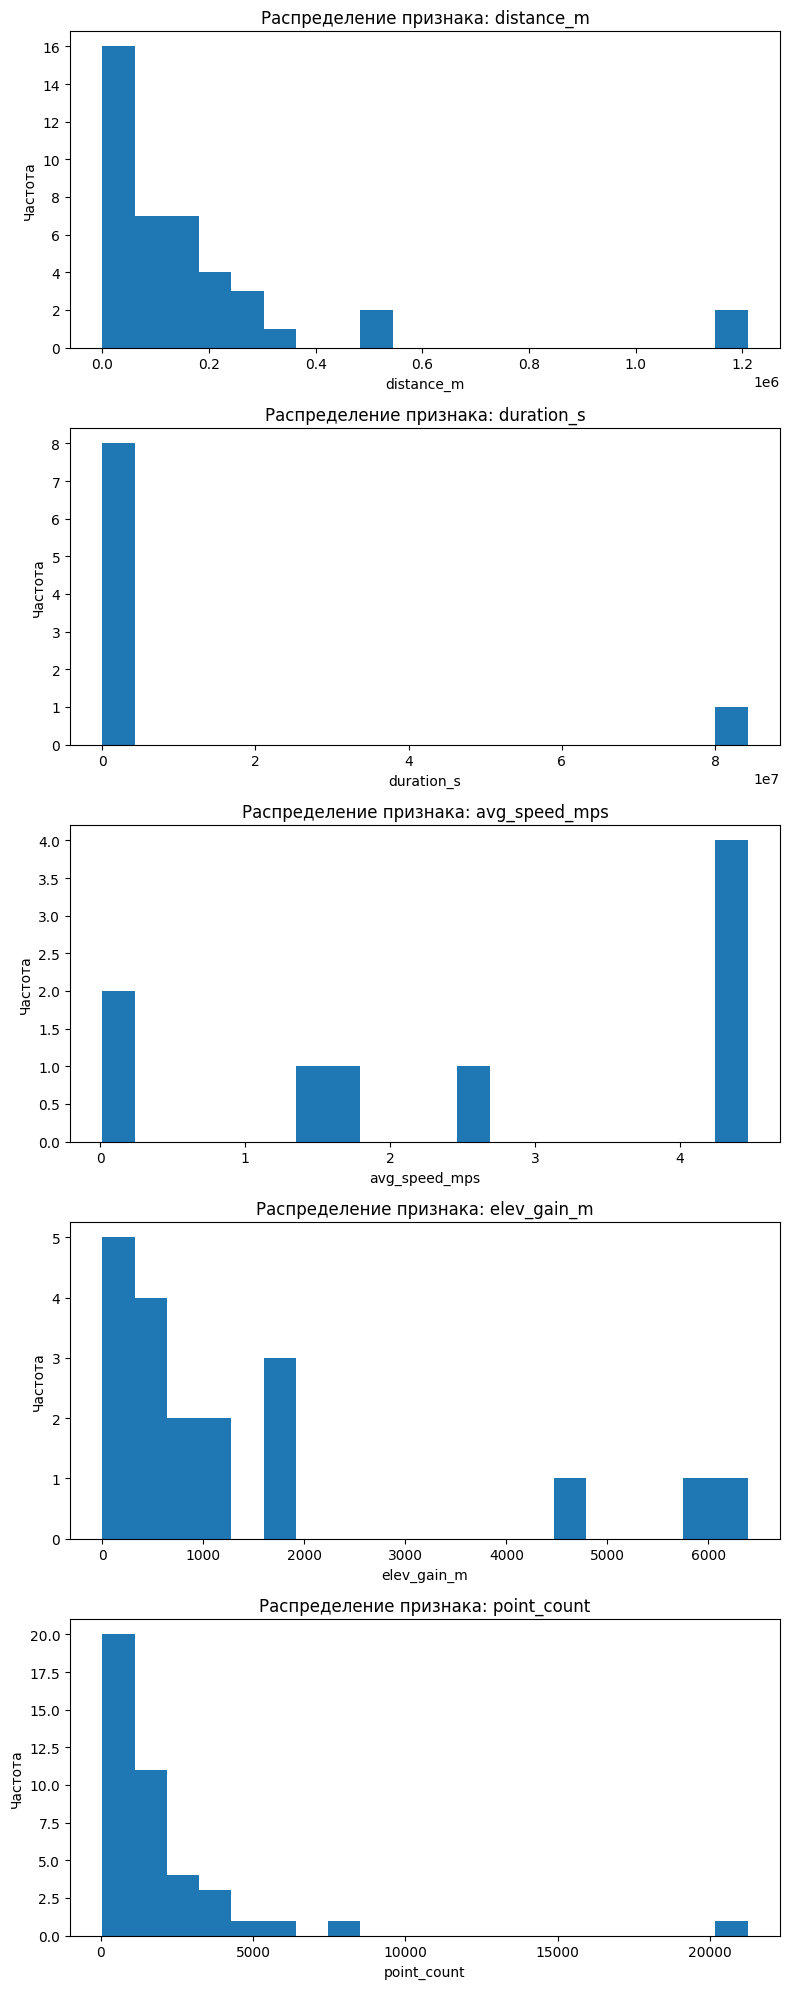


📐 СКОШЕННОСТЬ (skewness):
distance_m: skew = 2.92
duration_s: skew = 2.47
avg_speed_mps: skew = -0.26
elev_gain_m: skew = 1.64
point_count: skew = 4.31

🧪 ПРОВЕРКА НОРМАЛЬНОСТИ (Shapiro–Wilk):
distance_m: p-value = 0.0000 → НЕ нормальное
duration_s: p-value = 0.0000 → НЕ нормальное
avg_speed_mps: p-value = 0.0444 → НЕ нормальное
elev_gain_m: p-value = 0.0001 → НЕ нормальное
point_count: p-value = 0.0000 → НЕ нормальное

✅ Анализ распределений завершён.


In [18]:
# =========================
# МОДУЛЬ A — АНАЛИЗ РАСПРЕДЕЛЕНИЙ ПРИЗНАКОВ
# (скошенность + нормальность)
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, shapiro

# --- 1) Выберем ключевые признаки для анализа
# (на соревнованиях можно менять этот список под датасет)
analysis_features = [
    "distance_m",
    "duration_s",
    "avg_speed_mps",
    "elev_gain_m",
    "point_count",
]

print("📌 Анализируем признаки:")
print(analysis_features)

# --- 2) Подготовим таблицу без NaN (для статистики)
df_dist = df_ml[analysis_features].copy()

# Для статистических тестов удаляем NaN построчно
df_dist_clean = df_dist.dropna()

print("\n📊 Размер данных после удаления NaN:", df_dist_clean.shape)

# --- 3) Гистограммы распределений
fig, axes = plt.subplots(len(analysis_features), 1, figsize=(8, 4 * len(analysis_features)))

for i, col in enumerate(analysis_features):
    ax = axes[i]
    data = df_dist[col].dropna()
    ax.hist(data, bins=20)
    ax.set_title(f"Распределение признака: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Частота")

plt.tight_layout()
plt.show()

# --- 4) Скошенность (skewness)
print("\n📐 СКОШЕННОСТЬ (skewness):")

skew_results = {}
for col in analysis_features:
    data = df_dist[col].dropna()
    if len(data) >= 3:
        s = skew(data)
        skew_results[col] = s
        print(f"{col}: skew = {s:.2f}")
    else:
        print(f"{col}: недостаточно данных")

# --- 5) Проверка нормальности (Shapiro–Wilk)
print("\n🧪 ПРОВЕРКА НОРМАЛЬНОСТИ (Shapiro–Wilk):")

normality_results = {}
for col in analysis_features:
    data = df_dist[col].dropna()

    # Ограничение Shapiro: до ~5000 значений
    if len(data) >= 3 and len(data) <= 5000:
        stat, p = shapiro(data)
        normality_results[col] = p

        verdict = "НЕ нормальное" if p < 0.05 else "близко к нормальному"
        print(f"{col}: p-value = {p:.4f} → {verdict}")
    else:
        print(f"{col}: пропущено (слишком мало или много данных)")

print("\n✅ Анализ распределений завершён.")